In [1]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
from functools import partial

import torch
from Solver import *
# from NeuralNet import *
from timeit import default_timer

import sys
sys.path.append('../Utility')
import NeuralNet
import Numerics
import PlotDefault

In [2]:
L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
dy = yy[1] - yy[0]
f = -np.ones_like(yy)
dbc = np.array([0.0, 0.0]) 

In [3]:
# Training data
xx, f, q, q_c, dq_c = generate_data()

dq = np.copy(q)
ddq = np.copy(q)
for i in range(q.shape[0]):
    dq[i, :]  = Numerics.gradient_first(q[i,:], dy, bc = "one-sided")
    ddq[i, :] = Numerics.gradient_second(q[i,:], dy, bc = "one-sided")
  

100000 max q 0.15420940171016215
200000 max q 0.16105500139707368
300000 max q 0.1612135690621972
400000 max q 0.16121705302977674
500000 max q 0.1612171295332711
Last step increment is :  5.244638612664234e-07  last step is :  1.0869268110500834
100000 max q 0.22587322936901522
200000 max q 0.22798575440830837
300000 max q 0.22799540970998744
400000 max q 0.22799545330412824
500000 max q 0.22799545350094425
Last step increment is :  1.349271491532571e-09  last step is :  1.537146653703915
100000 max q 0.2784558907343084
200000 max q 0.27923521393101597
300000 max q 0.27923626097074616
400000 max q 0.27923626237508703
500000 max q 0.27923626237669746
Last step increment is :  1.10940588520717e-11  last step is :  1.8826124807061453
100000 max q 0.32211004034818674
200000 max q 0.3224341061004881
300000 max q 0.3224342624262979
400000 max q 0.3224342625014399
500000 max q 0.3224342625014399
Last step increment is :  0.0  last step is :  2.173853645031209
100000 max q 0.3603452553980225


In [4]:
# Test data
def f_func1(xx_test):
    return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2


def f_func2(xx_test):
    
    f = np.ones_like(xx_test)
    f[xx_test <= 0.5] = 0.0
    f[xx_test > 0.5] = 10.0
    return f

def f_func3(xx_test):
    L = 1
    return 10*np.sin(2*np.pi*xx_test/L)

f_funcs = [f_func1, f_func2, f_func3]

xx_test, f_test, q_test, q_c_test, dq_c_test = np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny)), np.zeros((3, Ny-1)), np.zeros((3, Ny-1))

for i in range(3):
    
    f_func = f_funcs[i]
    xx_test[i,:], f_test[i,:], q_test[i,:], q_c_test[i,:], dq_c_test[i,:] = generate_data_helper(permeability_ref, f_func, L=1.0, Nx = 100)
    

dq_test = np.copy(q_test)
ddq_test = np.copy(q_test)
for i in range(q_test.shape[0]):
    dq_test[i, :]  = Numerics.gradient_first(q_test[i,:], dy, bc = "one-sided")
    ddq_test[i, :] = Numerics.gradient_second(q_test[i,:], dy, bc = "one-sided")
  


100000 max q 0.38380414098810156
200000 max q 0.383879221159854
300000 max q 0.38387922651141576
400000 max q 0.38387922651153894
500000 max q 0.38387922651153894
Last step increment is :  0.0  last step is :  2.698857075128386
100000 max q 0.5298444646948456
200000 max q 0.5298574719709566
300000 max q 0.5298574721656208
400000 max q 0.5298574721656208
500000 max q 0.5298574721656208
Last step increment is :  0.0  last step is :  3.3879190373440613
100000 max q 0.23817591147248918
200000 max q 0.23817591147248918
300000 max q 0.23817591147248918
400000 max q 0.23817591147248918
500000 max q 0.23817591147248918
Last step increment is :  0.0  last step is :  1.5678034448063396


In [6]:
print("Training q range : ", q.min(), q.max(), " Test q range : ", q_test.min(), q_test.max())
print("Training dq range : ", dq.min(), dq.max(), " Test dq range : ", dq_test.min(), dq_test.max())
print("Training ddq range : ", ddq.min(), ddq.max(), " Test ddq range : ", ddq_test.min(), ddq_test.max())


Training q range :  0.0 0.4836513937524235  Test q range :  -0.2381759114724892 0.5298574721656208
Training dq range :  -1.7595914553733711 1.1654726738198768  Test dq range :  -2.0005060229501637 1.3999257227079138
Training ddq range :  -10.05594467084006 -0.014964606235287045  Test ddq range :  -32.411592322145 32.411592322145


In [7]:
mu, flux, source = np.copy(q), np.copy(q), np.copy(q)
for i in range(q.shape[0]):
    mu[i,:], flux[i,:], source[i,:] = permeability_ref(np.vstack((q[i,:], dq[i,:])).T), flux_ref(np.vstack((q[i,:], dq[i,:])).T), source_ref_q(q[i,:], dy)
    
mu_test, flux_test, source_test = np.copy(q_test), np.copy(q_test), np.copy(q_test)
for i in range(q_test.shape[0]):
    mu_test[i,:], flux_test[i,:], source_test[i,:] = permeability_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), flux_ref(np.vstack((q_test[i,:], dq_test[i,:])).T), source_ref_q(q_test[i,:], dy)


Text(0.5, 0, 'ddq')

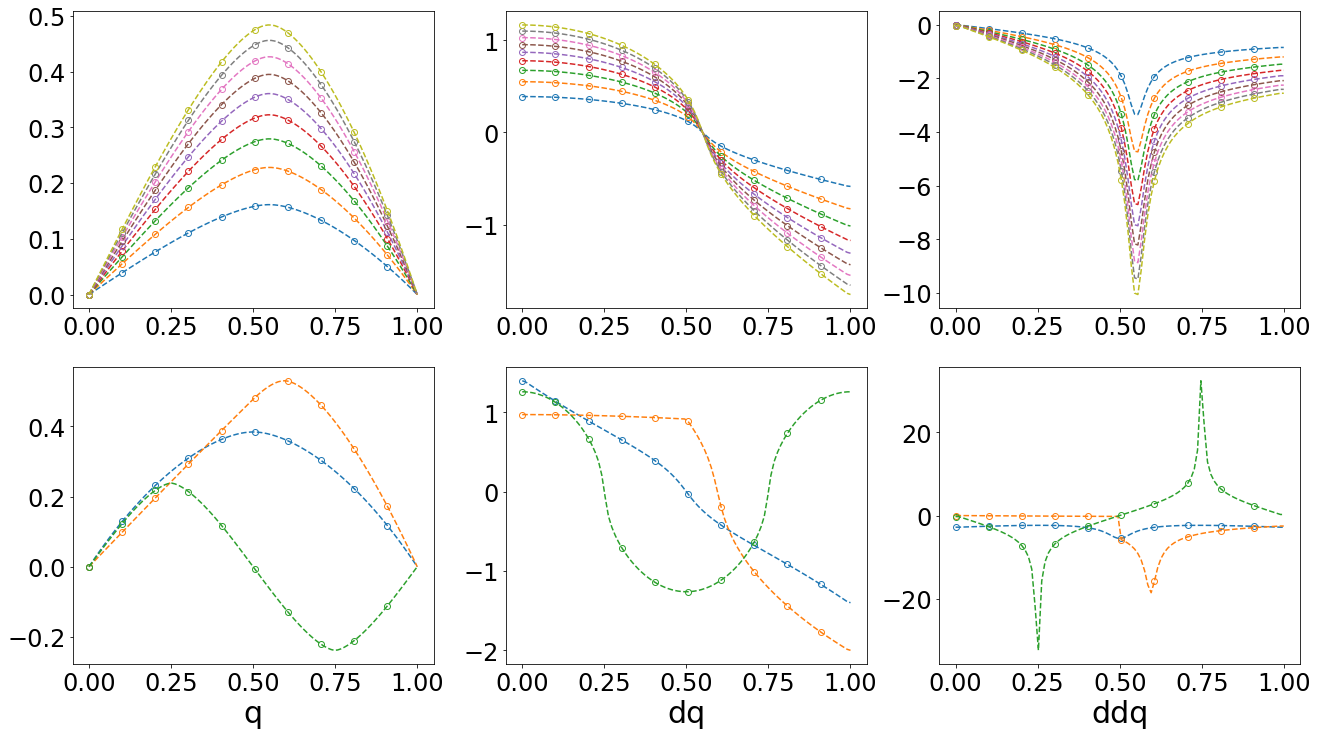

In [8]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=((22,12)))

for i in range(q.shape[0]):
    # Training data
    ax[0,0].plot(yy, q[i, :],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[0,1].plot(yy, dq[i, :],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[0,2].plot(yy, ddq[i, :],  "--o", color="C"+str(i), fillstyle="none", markevery=10)

for i in range(q_test.shape[0]):
    # Training data
    ax[1,0].plot(yy, q_test[i, :],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[1,1].plot(yy, dq_test[i, :],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[1,2].plot(yy, ddq_test[i, :],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
  
ax[1,0].set_xlabel("q")  
ax[1,1].set_xlabel("dq") 
ax[1,2].set_xlabel("ddq") 



Text(0.5, 0, 'source')

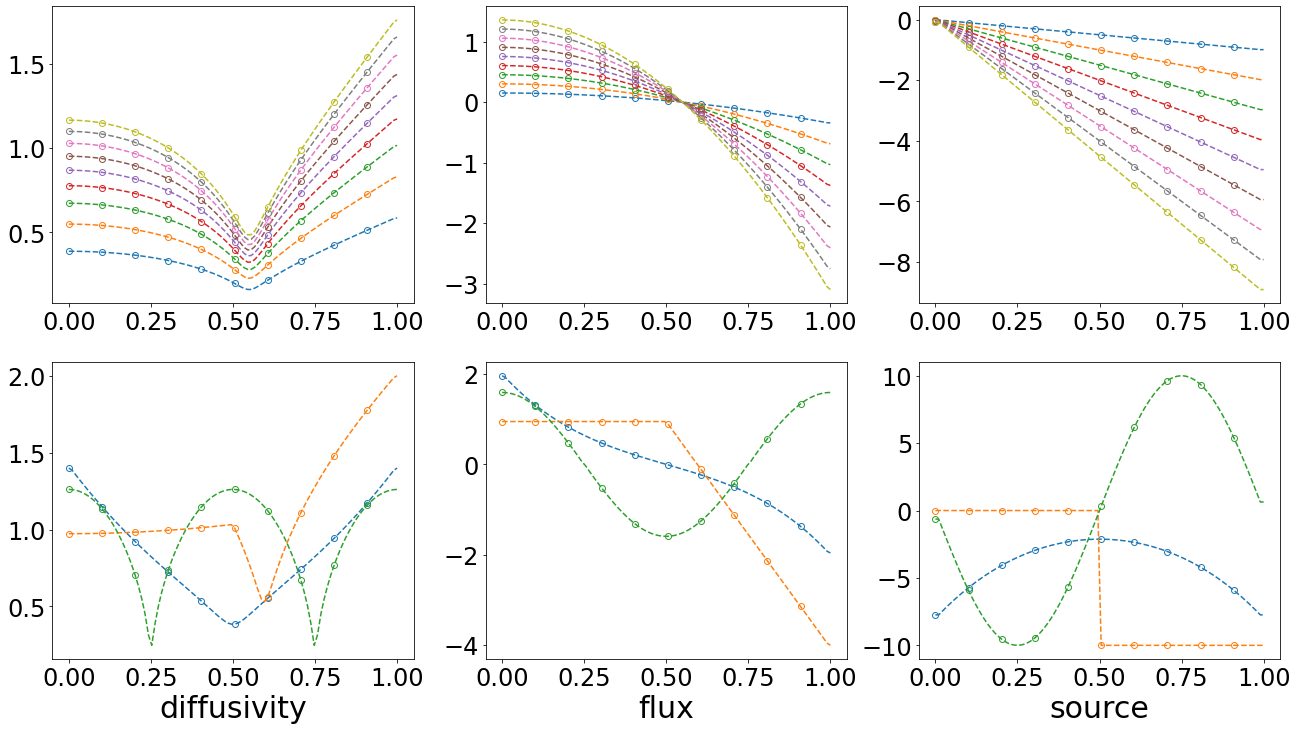

In [9]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=((22,12)))

for i in range(q.shape[0]):
    # Training data
    ax[0,0].plot(yy, mu[i,:],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[0,1].plot(yy, flux[i,:],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[0,2].plot(yy, source[i,:],  "--o", color="C"+str(i), fillstyle="none", markevery=10)

for i in range(q_test.shape[0]):
    # Training data
    ax[1,0].plot(yy, mu_test[i,:],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[1,1].plot(yy, flux_test[i,:],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
    ax[1,2].plot(yy, source_test[i,:],  "--o", color="C"+str(i), fillstyle="none", markevery=10)
  
ax[1,0].set_xlabel("diffusivity")  
ax[1,1].set_xlabel("flux") 
ax[1,2].set_xlabel("source") 

# Training a quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [3]:
def solve(ref_permeability, MODEL = "exp_nummodel", dt = 5.0e-6, Nt = 500000, save_every = 100000, L=1.0):
    if MODEL == "exp_nummodel":

        model = lambda q, yy, res : nummodel(ref_permeability, q, yy, res)
        yy_ref, t_data_ref, q_data_ref = explicit_solve(model, f, dbc, dt = dt, Nt = Nt, save_every = save_every, L = L)

    elif MODEL == "imp_nummodel":

        model = lambda q, yy, res, V : nummodel_jac(ref_permeability, q, yy, res, V, True, D_ref_permeability)  
        yy_ref, t_data_ref, q_data_ref = implicit_solve(model, f, dbc, dt = dt, Nt = Nt, save_every = save_every, L = L)

    elif MODEL == "imp_Newton_nummodel":

        model = lambda q, yy, res, V : nummodel_jac(ref_permeability, q, yy, res, V, True, D_ref_permeability)  
        yy_ref, t_data_ref, q_data_ref = implicit_Newton_solve(model, f, dbc, dt = dt, Nt = Nt, save_every = save_every, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)

    else:
        print("ERROR")


    plt.figure()
    plt.plot(yy_ref, q_data_ref[-1, :],  "--o", fillstyle="none", label="q")

    plt.xlabel("y")
    plt.legend()
    plt.show()


 



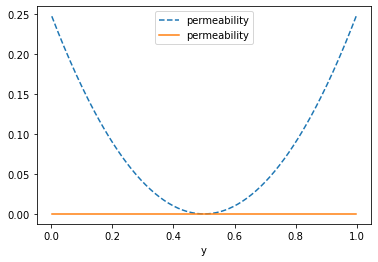

100000 max q 3.9941381927195634
200000 max q 4.991414297465661
300000 max q 5.149026332585167
400000 max q 5.173065641773646
500000 max q 5.176721860828194
600000 max q 5.17727782110645
700000 max q 5.177362358205832
800000 max q 5.177375212560493
900000 max q 5.177377167139006
1000000 max q 5.177377464343516


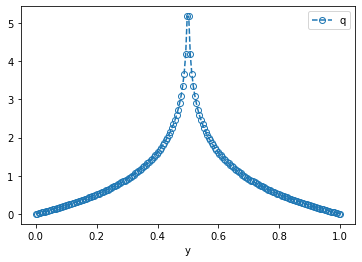

In [51]:
yy_c = (yy[0:-1] + yy[1:])/2.0
permeability = (yy_c - L/2)**2 
def ref_permeability(q, dq):
    return permeability
def D_ref_permeability(q, dq):
    return np.zeros_like(q), np.zeros_like(dq)


plt.figure()
plt.plot(yy_c, permeability,  "--", fillstyle="none", label="permeability")

plt.plot(yy_c, np.zeros_like(yy_c),  "-", fillstyle="none", label="permeability")

plt.xlabel("y")
plt.legend()
plt.show()

solve(ref_permeability, MODEL = "exp_nummodel", dt = 5.0e-5, Nt = 1000000)
#solve(ref_permeability, MODEL = "imp_nummodel", dt = 1.0e-2, Nt = 2000)

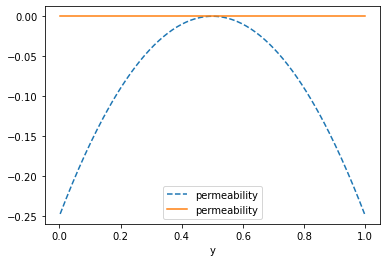

1 max q:  0.00035626908533671517  L2 res:  14.071247279470288
2 max q:  0.01046005942080928  L2 res:  18.703330536982133


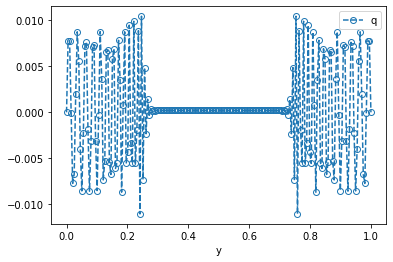

In [11]:
yy_c = (yy[0:-1] + yy[1:])/2.0
permeability = -(yy_c - L/2)**2 
def ref_permeability(q, dq):
    return permeability
def D_ref_permeability(q, dq):
    return np.zeros_like(q), np.zeros_like(dq)


plt.figure()
plt.plot(yy_c, permeability,  "--", fillstyle="none", label="permeability")

plt.plot(yy_c, np.zeros_like(yy_c),  "-", fillstyle="none", label="permeability")

plt.xlabel("y")
plt.legend()
plt.show()

#solve(ref_permeability, MODEL = "exp_nummodel", dt = 5.0e-5, Nt = 1000000)
solve(ref_permeability, MODEL = "imp_nummodel", dt = 1.0e-4, Nt = 2, save_every=1)

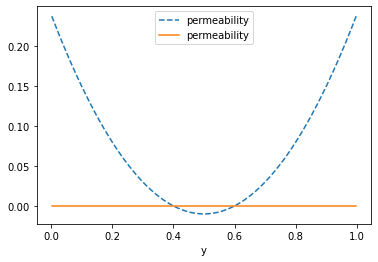

../Utility/Numerics.py:47: RuntimeWarning: overflow encountered in true_divide
  d_omega = (omega[1:nx] - omega[0:nx-1]) / (dx)
../Utility/Numerics.py:59: RuntimeWarning: invalid value encountered in add
  c_omega = (omega[0:nx-1] + omega[1:nx]) / 2.0
../Utility/Numerics.py:47: RuntimeWarning: invalid value encountered in subtract
  d_omega = (omega[1:nx] - omega[0:nx-1]) / (dx)


100000 max q nan
200000 max q nan
300000 max q nan
400000 max q nan
500000 max q nan
600000 max q nan


KeyboardInterrupt: 

In [16]:
yy_c = (yy[0:-1] + yy[1:])/2.0
permeability = (yy_c - L/2)**2 - 0.01
def ref_permeability(q, dq):
    return permeability
def D_ref_permeability(q, dq):
    return np.zeros_like(q), np.zeros_like(dq)


plt.figure()
plt.plot(yy_c, permeability,  "--", fillstyle="none", label="permeability")

plt.plot(yy_c, np.zeros_like(yy_c),  "-", fillstyle="none", label="permeability")

plt.xlabel("y")
plt.legend()
plt.show()

solve(ref_permeability, MODEL = "exp_nummodel", dt = 5.0e-5, Nt = 1000000)


In [17]:
yy_c = (yy[0:-1] + yy[1:])/2.0
permeability = (yy_c - L/2)**2 - 0.01
def ref_permeability(q, dq):
    return q
def D_ref_permeability(q, dq):
    return  np.ones_like(q), np.zeros_like(dq)


# plt.figure()
# plt.plot(yy_c, permeability,  "--", fillstyle="none", label="permeability")

# plt.plot(yy_c, np.zeros_like(yy_c),  "-", fillstyle="none", label="permeability")

# plt.xlabel("y")
# plt.legend()
# plt.show()

solve(ref_permeability, MODEL = "exp_nummodel", dt = 1.0e-5, Nt = 1000000)


/central/home/dzhuang/Code/Point-Jet/Poisson_model/Solver.py:228: RuntimeWarning: overflow encountered in multiply
  res[:] = gradient_first_c2f(mu_c*(dq_c), dy)
../Utility/Numerics.py:33: RuntimeWarning: invalid value encountered in subtract
  d_omega = (omega[1:nx] - omega[0:nx-1]) / (dx)


100000 max q nan
200000 max q nan


KeyboardInterrupt: 